# Skeleton of an ellipse

## Preliminaries

### Packages

In [1]:
import numpy as np
import nutopy as nt
import os
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.rcParams['figure.dpi'] = 140
plt.rcParams.update({"text.usetex":True, "font.family":"sans-serif", "font.sans-serif":["Helvetica"]})

### Hamiltonian: compilation of Fortran code

The Hamiltonian is 
$$
H=\frac{1}{2}\left( p_x^2 + p_y^2 \right).
$$

In [2]:
# Fortran Hamiltonian code
!pygmentize hfun.f90

subroutine hfun(x, p, h)

    double precision, intent(in)  :: x(2), p(2)
    double precision, intent(out) :: h

    h = 0.5d0 * (p(1)**2 + p(2)**2)

end subroutine hfun


In [3]:
# Compilation of the hamiltonian and associated derivatives up to order 3

!python -m numpy.f2py -c hfun.f90       -m hfun       > /dev/null 2>&1
!python -m numpy.f2py -c hfun_d.f90     -m hfun_d     > /dev/null 2>&1
!python -m numpy.f2py -c hfun_d_d.f90   -m hfun_d_d   > /dev/null 2>&1
!python -m numpy.f2py -c hfun_d_d_d.f90 -m hfun_d_d_d > /dev/null 2>&1

from hfun       import hfun       as hf
from hfun_d     import hfun_d     as hf_d
from hfun_d_d   import hfun_d_d   as hf_d_d
from hfun_d_d_d import hfun_d_d_d as hf_d_d_d

In [ ]:
# parameterization of initial state and costate

!python -m numpy.f2py -c point.f90 curve_d.f90 -m point       > /dev/null 2>&1
!python -m numpy.f2py -c point_d.f90           -m point_d     > /dev/null 2>&1
!python -m numpy.f2py -c point_d_d.f90         -m point_d_d   > /dev/null 2>&1

from point       import point       as ip
from point_d     import point_d     as ip_d
from point_d_d   import point_d_d   as ip_d_d

### Initialization

In [5]:
datafile = "data.json"

def savedata(d):
    file = open(datafile, "w")
    json.dump(d,file)
    file.close()    

# Parameters

restart = False

if os.path.isfile(datafile) and not(restart):
    file   = open(datafile, "r")
    data   = json.load(file)
    t0     = data.get('t0')
    r1     = data.get('r1')
    r2     = data.get('r2')
    print('data loaded')
else:

    # radius
    r1 = 10.0
    r2 =  6.0
    
    # initial time
    t0     = 0.0

    # Data
    data = {'t0': t0, 'r1': r1, 'r2': r2}

    # Save data
    savedata(data)
    print('data saved')

data loaded


### Hamiltonian flow and the exponential mapping

From the Hamiltonian $H$, we define the *Hamiltonian system* 

$$
\vec{H}(q,p) := \left(\nabla_p H(q,p), -\nabla_q H(q,p)\right).
$$

The *exponential mapping* $\exp(t \vec{H})$ is then defined by

$$
\exp(t \vec{H})(t_0, q_0, p_0) := z(t, t_0, q_0, p_0),
$$

where $z(t_f, t_0, x_0, p_0)$ is the solution at time $t_f$ of the Cauchy problem

$$
\dot{z}(t) = \vec{H}(z(t)), \quad z(t_0) = (q_0, p_0).
$$

In [6]:
# Hamiltonian and derivatives
hfun   = lambda t, x, p                   : hf(x, p)
dhfun  = lambda t, x, dx, p, dp           : hf_d(x, dx, p, dp)
d2hfun = lambda t, x, dx, d2x, p, dp, d2p : hf_d_d(x, d2x, dx, p, d2p, dp)
d3hfun = lambda t, x, dx, d2x, d3x, p, dp, d2p, d3p : hf_d_d_d(x, d3x, d2x, dx, p, d3p, d2p, dp)

hfun   = nt.tools.tensorize(dhfun, d2hfun, d3hfun, tvars=(2, 3), full=True)(hfun)
h      = nt.ocp.Hamiltonian(hfun)

# Exponential mapping and its derivatives
exponential = nt.ocp.Flow(h)

### Parameterization of the initial covector

By homogeneity, we can fix $H = 1/2$ and that is we fix $||p_0||=1$.

In [7]:
# Initial state-costate parameterization and derivatives
initial_point   = lambda alpha                   : ip(alpha)
dinitial_point  = lambda alpha, dalpha           : ip_d(alpha, dalpha)
d2initial_point = lambda alpha, dalpha, d2alpha  : ip_d_d(alpha, d2alpha, dalpha)

initial_point   = nt.tools.tensorize(dinitial_point, d2initial_point, tvars=(1,), full=True)(initial_point)

## Geodesics

A geodesic is the projection of an extremal given by the exponential mapping. That is

$$
\exp(t, \alpha) = \pi_q \left( \exp(t \vec{H})(t_0, q_0(\alpha), p_0(\alpha)) \right),
$$

where $\pi_q(q, p) = q$ is the canonical projection on the state space.

In [8]:
# Compute a geodesic parameterized by alpha to time t
def geodesic(t, alpha):
    N      = 100
    tspan  = list(np.linspace(t0, t, N+1))
    q0, p0 = initial_point(alpha)
    q, p   = exponential(t0, q0, p0, tspan)
    return q

In [9]:
# Initial plotting
def plotInitFig():
    
    # 2D
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    r = 2*r1
    x = [-r, r, r, -r]
    y = [-r, -r, r, r]
    ax.fill(x, y, color=(0.95, 0.95, 0.95))
    
    circle = patches.Ellipse((0,0), 2.*r1, 2.*r2, ec="black", fc='white')
    ax.add_patch(circle)
    
    ax.set_xlabel(r'$x$', fontsize=16)
    ax.set_ylabel(r'$y$', fontsize=16)
    ax.axis('equal')
    plt.xlim(-1.1*r1, 1.1*r1);
    plt.ylim(-1.1*r1, 1.1*r1);
    
    ax2D = ax

    return ax2D

# function to plot geodesics
def plotGeodesics(ax2d=None, nb_geodesics=15, tf=2.*r1):
    if ax2d is None:
        ax2d = plotInitFig()
    
    alphas = np.linspace(0.0, 2.0*np.pi, nb_geodesics)
    for alpha in alphas[0:-1]:
        q = np.array(geodesic(tf, alpha))
        ax2d.plot(q[:,0], q[:,1], color='b', linewidth=0.5)
        
    return ax2d

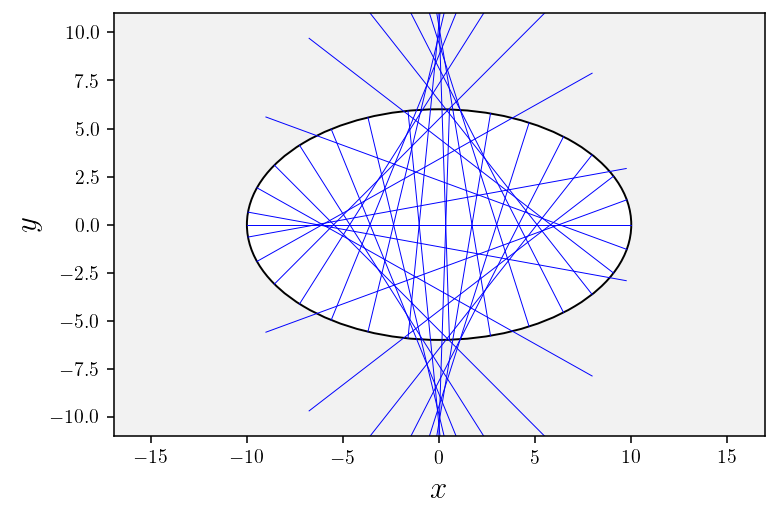

In [10]:
# Plot geodesics
plotGeodesics(nb_geodesics=30);

## Conjugate locus

### Jacobi fields

A Jacobi field is a solution of the variational equation of the exponential mapping.

In [11]:
# Canonical first projection of the Jacobi field: dq(t, p0(alpha), dp0(alpha)), 
# with J = (dq, dp) the Jacobi field
@nt.tools.vectorize(vvars=(1,))
def jacobi(t, alpha):
    q0, dq0, p0, dp0 = initial_point((alpha, 1.))
    (q, dq), _ = exponential(t0, (q0, dq0), (p0, dp0), t)
    return dq

In [12]:
# Derivative of jacobi
def djacobi(t, alpha):
    q0, dq0, d2q0, p0, dp0, d2p0 = initial_point ((alpha, 1., 1.))
    (q, dq1, d2q), (p, dp1, _) = exponential(t0, (q0, dq0, dq0), (p0, dp0, dp0), t)
    (q, dq2), (p, dp2) = exponential(t0, (q0, d2q0), (p0, d2p0), t)
    # djacobi/dalpha
    djda = d2q+dq2
    # djacobi/dt
    hv, dhv  = h.vec(t, (q, dq1), (p, dp1))
    djdt = dhv[0:2]
    return djdt, djda

### Equation for the calculation of conjugate points

<table style="font-size:100%" align="left">
<tr>
  <td><img src="conjugate_point.png" width="400px"></td>
  <td style="padding-left:10px; vertical-align:top">
Let $q$ being a reference geodesic and $J := (\delta q, \delta p)$ the associated Jacobi field.

A conjugate time $t_c$ along $q$ is a solution of the equation

$$
    t \mapsto \det \left(\dot{q}(t), \delta q(t) \right).
$$

A conjugate point is the associated point: $q(t_c)$.
</td>
</tr>
</table>

In [13]:
# conjugate(t, q, a) = ( det(jacobi(t, a), Hv(t, z(t, a))), q - pi_q(z(t, a)) ),
# where pi_q(q, p) = q and z(t, a) = exponential(t0, q0, p0(q0, a), t).
#
# Remark: y = (t, q)
#
def conjugate(y, a):
    t      = y[0]
    q      = y[1:3]
    alpha  = a[0]
    #
    dq     = jacobi(t, alpha)
    #
    q0, p0 = initial_point(alpha)
    qt, pt = exponential(t0, q0, p0, t)
    hv     = h.vec(t, qt, pt)[0:2]
    #
    c      = np.zeros(3)
    c[0]   = np.linalg.det([hv, dq])
    c[1:3] = q - qt
    return c

In [14]:
# Derivative of conjugate
def dconjugate(y, a):
    t     = y[0]
    x     = y[1:3]
    alpha = a[0]
    #
    dx    = jacobi(t, alpha)
    #
    ddxdt, ddxda = djacobi(t, alpha)
    #
    q0, dq0, p0, dp0     = initial_point((alpha, 1.))
    (xf, dxf), (pf, dpf) = exponential(t0, (q0, dq0), (p0, dp0), t)
    hv, dhv              = h.vec(t, (xf, dxf), (pf, dpf))
    #
    # dc/da
    dcda        = np.zeros((3, 1))
    dcda[0,0]   = np.linalg.det([dhv[0:2], dx])+np.linalg.det([hv[0:2], ddxda])
    dcda[1:3,0] = -dxf
    #
    # dc/dy = (dc/dt, dc/dx)
    hv, dhv     = h.vec(t, (xf, hv[0:2]), (pf, hv[2:4]))
    dcdy        = np.zeros((3, 3))
    dcdy[0,0]   = np.linalg.det([dhv[0:2], dx])+np.linalg.det([hv[0:2], ddxdt])
    dcdy[1:3,0] = -hv[0:2]
    dcdy[1,1]   = 1.
    dcdy[2,2]   = 1.
    return dcdy, dcda

### Conjugate locus

In [15]:
def get_conjugate_locus():

    # -------------------------
    # Get first conjugate point
    
    # Initial guess
    gap    = 1e-2
    tci    = np.pi
    alpha  = np.array([-np.pi/2+gap])
    q0, p0 = initial_point(float(alpha))
    xi, pi = exponential(t0, q0, p0, tci)

    yi      = np.zeros(3)
    yi[0]   = tci
    yi[1:3] = xi

    # Equations and derivative
    fun   = lambda t: conjugate(t, alpha)
    dfun  = lambda t: dconjugate(t, alpha)[0]

    # callback
    def print_conjugate_time(infos):
        print('    Conjugate time estimation: tc = %e for alpha = %e' % (infos.x[0], alpha), end='\r')
    
    # Options
    opt  = nt.nle.Options(Display='off')

    # Conjugate point calculation
    print(' > Get first conjugate time and point:\n')
    sol   = nt.nle.solve(fun, yi, df=dfun, callback=print_conjugate_time, options=opt)
    
    # -------------------   
    # Get conjugate locus

    # options
    opt = nt.path.Options(MaxStepSizeHomPar=0.05, Display='off');

    # homotopic parameter range
    alpha0  = alpha
    alphaf  = np.pi/2.-gap

    # initial solution
    y0 = sol.x

    # callback
    def progress(infos):
        current   = float(infos.pars)-alpha0
        total     = alphaf-alpha0
        barLength = 50
        percent   = float(current * 100.0 / total)
        arrow     = '-' * int(percent/100 * barLength - 1) + '>'
        spaces    = ' ' * (barLength - len(arrow))

        print('    Progress: [%s%s] %1.2f %%' % (arrow, spaces, round(percent, 2)), end='\r')
    
    # Conjugate locus calculation
    print('\n\n > Get conjugate locus:\n')
    sol = nt.path.solve(conjugate, y0, alpha0, alphaf, options=opt, df=dconjugate, callback=progress)
    print('\n')
    
    return sol.xout

# Plot conjugate locus
def plotConjugateLocus(conjugate_locus, ax2d=None):
    if ax2d is None:
        ax2d = plotInitFig()
    #
    ax2d.plot(  conjugate_locus[:,1], conjugate_locus[:,2], color='r', linewidth=1.0)
    ax2d.plot( -conjugate_locus[:,1], conjugate_locus[:,2], color='r', linewidth=1.0)
    return ax2d

In [16]:
# Get conjugate locus
if 'conjugate_locus' in data.keys():
    conjugate_locus = np.array(data.get('conjugate_locus'))
    print('Conjugate locus loaded')
else:
    conjugate_locus = get_conjugate_locus()
    data['conjugate_locus'] = conjugate_locus.tolist()
    savedata(data)
    print('Conjugate locus saved')

Conjugate locus loaded


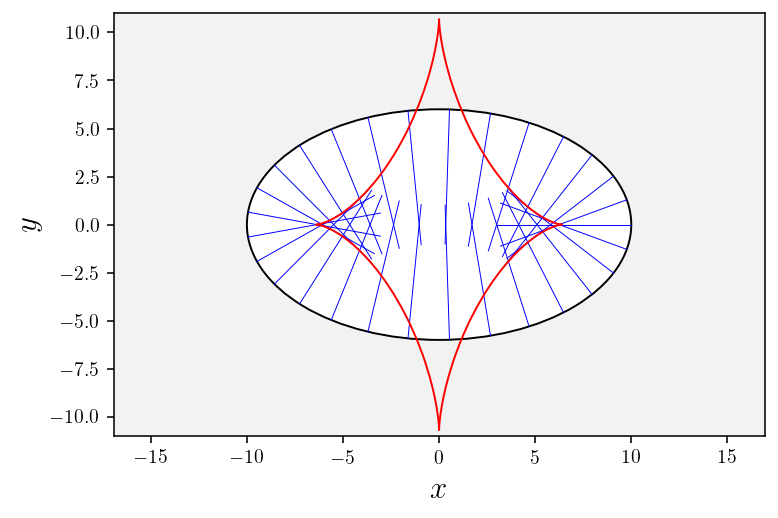

In [17]:
# Plot geodesics
ax2d = plotGeodesics(nb_geodesics=30, tf=7.)
    
# Plot conjugate locus
plotConjugateLocus(conjugate_locus, ax2d);

## Wavefronts

The wavefront at time $t$ is simply given by

$$
\{ ~q~ | ~q = \exp(t, \alpha), ~\alpha \in [0, 2\pi) \}.
$$

In [18]:
# Equation to calculate wavefronts
def wavefront_eq(q, alpha, tf):
    q0, p0 = initial_point(float(alpha))
    qf, _  = exponential(t0, q0, p0, tf)
    return q - qf

In [19]:
# Derivative
def dwavefront_eq(q, dq, alpha, dalpha, tf):
    q0, dq0, p0, dp0 = initial_point((float(alpha), float(dalpha)))
    (qf, dqf), _ = exponential(t0, (q0, dq0), (p0, dp0), tf)
    return q - qf, dq - dqf
    
wavefront_eq = nt.tools.tensorize(dwavefront_eq, tvars=(1, 2), full=True)(wavefront_eq)

In [20]:
def get_wavefront(tf):

    # Options
    opt = nt.path.Options(Display='off', MaxStepSizeHomPar=0.1, MaxIterCorrection=0);

    # Homotopic parameter range
    alpha0  = 0.0
    alphaf  = 2.0*np.pi

    # Initial solution
    q0, p0 = initial_point(alpha0)
    xf0, _ = exponential(t0, q0, p0, tf)

    # callback
    def progress(infos):
        current   = float(infos.pars)-alpha0
        total     = alphaf-alpha0
        barLength = 50
        percent   = float(current * 100.0 / total)
        arrow     = '-' * int(percent/100.0 * barLength - 1) + '>'
        spaces    = ' ' * (barLength - len(arrow))

        print('    Progress: [%s%s] %1.2f %%' % (arrow, spaces, round(percent, 2)), end='\r')
    
    # wavefront computation
    print('\n > Get wavefront for tf =', tf, '\n')
#    sol = nt.path.solve(wavefront_eq, xf0, alpha0, alphaf, args=tf, options=opt, callback=progress)
    sol = nt.path.solve(wavefront_eq, xf0, alpha0, alphaf, args=tf, options=opt, df=wavefront_eq, callback=progress)
    print('\n')
    
    wavefront = (sol.xout, sol.parsout, tf)
    
    return wavefront

In [21]:
def plotWavefront(wavefront, ax2d=None):
    if ax2d is None:
        ax2d = plotInitFig()
    #
    ax2d.plot( wavefront[:,0], wavefront[:,1], color='g', linewidth=1.0)
    return ax2d

In [22]:
# Calculate wavefront
if 'wavefronts' in data.keys():
    wavefronts = data.get('wavefronts')
    print('Wavefronts loaded')
else:
    wavefronts = []
    wavefront  = get_wavefront(tf=2.0); wavefronts.append((wavefront[0].tolist(), wavefront[1].tolist(), wavefront[2]))
    wavefront  = get_wavefront(tf=5.5); wavefronts.append((wavefront[0].tolist(), wavefront[1].tolist(), wavefront[2]))
    data['wavefronts'] = wavefronts
    savedata(data)
    print('Wavefronts saved')

Wavefronts loaded


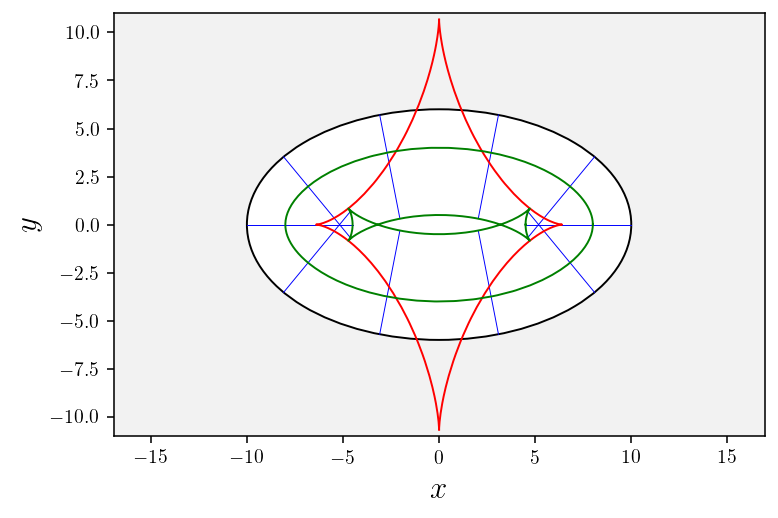

In [23]:
# Plot geodesics
ax2d = plotGeodesics(nb_geodesics=11, tf=5.5)

# Plot conjugate locus
plotConjugateLocus(conjugate_locus, ax2d)

# Plot wavefronts
for w in wavefronts:
    wavefront  = np.array(w[0]); plotWavefront(wavefront, ax2d);

## Cut locus

We call a *splitting point* a point where two minimizing geodesics intesect. In the Riemanian case, this corresponds to self-intersection of the wavefront.

We call a *cut point* along a reference geodesic the point where this geodesic loses its optimality.

We have that a cut point is either a conjugate point or a splitting point.

<table style="font-size:100%;align:left;text-align:center">
<tr>
  <td> <img src="splitting_point.png" width="400px"></td>
  <td> <img src="conjugate_point.png" width="400px"> </td>
</tr>
<tr>
  <td> Splitting point</td>
  <td> Conjugate point </td>
</tr>
</table>

### Self-intersection of the wavefront

In [24]:
def get_self_intersection(curve):
    n = curve[:,0].size
    intersections = []
    for i in range(n-3):
        A = curve[i,:]
        B = curve[i+1,:]
        for j in range(i+2,n-1):
            C = curve[j,:]
            D = curve[j+1,:]
            # Matrice M : M z = b
            m11 = B[0] - A[0]
            m12 = C[0] - D[0]
            m21 = B[1] - A[1]
            m22 = C[1] - D[1]
            det = m11*m22-m12*m21
            if(np.abs(det)>1e-8):
                b1 = C[0] - A[0]
                b2 = C[1] - A[1]
                la = (m22*b1-m12*b2)/det
                mu = (m11*b2-m21*b1)/det
                if(la>=0. and la<=1. and mu>=0. and mu<=1.):
                    xx = {'i': i, 'j': j, 'x': np.array(A + la * (B-A)), 'la': la, 'mu': mu}
                    intersections.append(xx)
    return intersections                     

In [25]:
wa        = wavefronts[-1]
wavefront = np.array(wa[0])
alphas    = np.array(wa[1])
tf        = wa[2]
xxs       = get_self_intersection(wavefront)
xx        = xxs[0]
x         = xx.get('x')
i         = xx.get('i')
j         = xx.get('j')
la        = xx.get('la')
mu        = xx.get('mu')
alpha1    = alphas[i]+la*(alphas[i+1]-alphas[i])
alpha2    = alphas[j]+mu*(alphas[j+1]-alphas[j])

print('Self-intersection of the wavefront for tf =', tf, 'at x = (', x[0], ',', x[1], ')\n')
print('alpha1 =', alpha1)
print('alpha2 = ', alpha2)

Self-intersection of the wavefront for tf = 5.5 at x = ( 3.1965134103212356 , -3.283815059361428e-05 )

alpha1 = 1.0477472419890679
alpha2 =  5.235416311093603


In [26]:
# Equations to calculate splitting locus
def split_eq(y, alpha):
    # y = (q, a, t)
    q     = y[0:2]
    a     = y[2]
    t     = y[3]
    b     = float(alpha)
    q0, p0 = initial_point(a)
    q1, _ = exponential(t0, q0, p0, t)
    q0, p0 = initial_point(b)
    q2, _ = exponential(t0, q0, p0, t)
    eq    = np.zeros(4)
    eq[0:2] = q-q1
    eq[2:4] = q1-q2   
    return eq

In [27]:
# Derivative
def dsplit_eq(y, dy, alpha, dalpha):
    x     = y[0:2]
    a     = y[2]
    t     = y[3]
    dx    = dy[0:2]
    da    = dy[2]
    dt    = dy[3]
    b     = float(alpha)
    db    = float(dalpha)
    
    q0, dq0, p0, dp0 = initial_point((a, da))
    (x1, dx1), _ = exponential(t0, (q0, dq0), (p0, dp0), (t, dt))
    
    q0, dq0, p0, dp0 = initial_point((b, db))
    (x2, dx2), _ = exponential(t0, (q0, dq0), (p0, dp0), (t, dt))
    
    deq      = np.zeros(4)
    deq[0:2] = dx-dx1
    deq[2:4] = dx1-dx2  
    return deq
    
split_eq = nt.tools.tensorize(dsplit_eq, tvars=(1, 2))(split_eq)

In [28]:
def get_splitting_locus(q, a, t, b):

    # Options
    opt = nt.path.Options(Display='off', MaxStepSizeHomPar=0.1, MaxIterCorrection=7);

    # Homotopic parameter range
    epsi    = 1e-2
    alpha0  = np.pi+epsi
    alphaf  = 2.0*np.pi-epsi

    # Initial solution
    y0 = np.array([q[0], q[1], a, t])
    b0 = b
    
    # callback
    def progress_bis(infos):
        current   = b0-float(infos.pars)
        total     = alphaf-alpha0+b0-alpha0
        barLength = 50
        percent   = float(current * 100.0 / total)
        arrow     = '-' * int(percent/100.0 * barLength - 1) + '>'
        spaces    = ' ' * (barLength - len(arrow))

        print('    Progress: [%s%s] %1.2f %%' % (arrow, spaces, round(percent, 2)), end='\r')
        
    # First homotopy
    print('\n > Get splitting locus\n')
    sol = nt.path.solve(split_eq, y0, b0, alpha0, options=opt, df=split_eq, callback=progress_bis)
    ysol = sol.xf

    # callback
    def progress(infos):
        current   = b0-float(infos.pars)+float(infos.pars)-alpha0
        total     = alphaf-alpha0+b0-alpha0
        barLength = 50
        percent   = float(current * 100.0 / total)
        arrow     = '-' * int(percent/100.0 * barLength - 1) + '>'
        spaces    = ' ' * (barLength - len(arrow))

        print('    Progress: [%s%s] %1.2f %%' % (arrow, spaces, round(percent, 2)), end='\r')
    
    # splitting computation
    sol = nt.path.solve(split_eq, ysol, alpha0, alphaf, options=opt, df=split_eq, callback=progress)
    print('\n')
    
    splitting_locus = sol.xout
    
    return splitting_locus

In [29]:
def plotSplitting(splitting_locus, ax2d=None):
    if ax2d is None:
        ax2d = plotInitFig()
    #
    ax2d.plot( splitting_locus[:,0], splitting_locus[:,1], color='k', linewidth=1)
    return ax2d

In [30]:
# Get splitting locus
if 'splitting_locus' in data.keys():
    splitting_locus = np.array(data.get('splitting_locus'))
    print('Splitting locus loaded')
else:
    splitting_locus = get_splitting_locus(x, alpha1, tf, alpha2)
    data['splitting_locus'] = splitting_locus.tolist()
    savedata(data)
    print('Splitting locus saved')

Splitting locus loaded


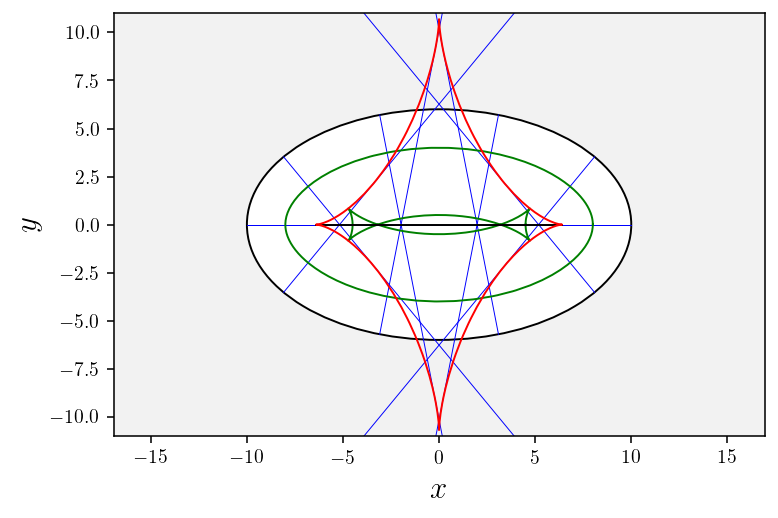

In [31]:
# Plot geodesics
ax2d = plotGeodesics(nb_geodesics=11)

# Plot wavefronts
for w in wavefronts:
    wavefront  = np.array(w[0]); plotWavefront(wavefront, ax2d)
    
# plot splitting locus
plotSplitting(splitting_locus, ax2d)

# Plot conjugate locus
plotConjugateLocus(conjugate_locus, ax2d);

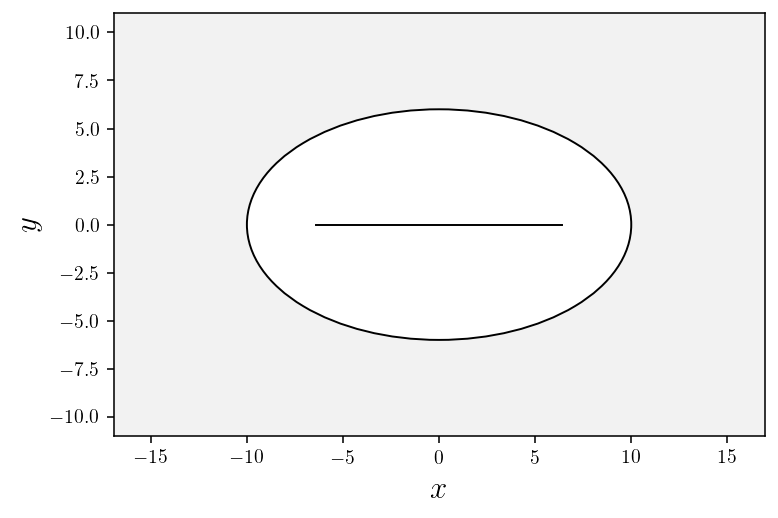

In [32]:
# plot splitting locus
plotSplitting(splitting_locus);

[thumbnail](skeleton.png)